<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.08.Colab_S1_Data_Viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Data Cube Configuration and Import Utilities

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

# Sentinel-1 Data Viewer
This notebook is used to review Sentinel-1 data over a specified region. The notebook includes several different data products including single data analyses and multi-date products. This data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter intensity (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from early 2017 for the globe. It is important to note that this data does NOT include radiometric terrain correction so there are issues using this data in areas with high elevation variation due to layover and shadowing.  
<br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

In [ ]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Cloud_Statistics')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Select and data platform and product
platform = ['Sentinel-1A']
product = ['s1_google']

## <span id="define_extents">Define the Extents of the Analysis and View [&#9652;](#top)</span>

In [ ]:
# MODIFY HERE

# Select the center of an analysis region (lat_long) 
# Adjust the surrounding box size (box_size) around the center (in degrees)
# Remove the comment tags (#) below to change the sample location

# Bangladesh (Rice Cropping)
lat_long = (22.60, 89.29)
box_size_deg = 0.10

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Time Period
# Consistent time series data is available from Jan-2017
time_extents = ('2020-01-01', '2020-06-01')

In [ ]:
display_map(latitude, longitude)

## Load the Data and View the Available Dates

In [ ]:
product = "s1_google"

measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
VV,VV,float32,,0,[single_co_polarization_vertical_transmitorver...,NaN
VH,VH,float32,,0,[dual_band_cross_polarization_vertical_transmi...,NaN
angle,angle,float32,Degrees,0,"[approximate_viewing_incidence_angle, angle]",NaN


In [ ]:
sar_dataset = dc.load(product=product, platform=platform, measurements=['VV','VH'], 
                      time=time_extents, lat=latitude, lon=longitude, group_by='solar_day')

In [ ]:
# Show acquisition indices and dates
pd.DataFrame(list(sar_dataset.time.values.astype('datetime64[D]')),columns=['Acquisition Date'])

,Acquisition Date
0,2020-01-05
1,2020-01-08
2,2020-01-17
3,2020-01-20
4,2020-01-29
5,2020-02-01
6,2020-02-10
7,2020-02-13
8,2020-02-22
9,2020-02-25


## View Histogram Plots

In [ ]:
# MODIFY HERE

# Choose a single time slice by its index (listed above)
acq_ind_to_show = 1

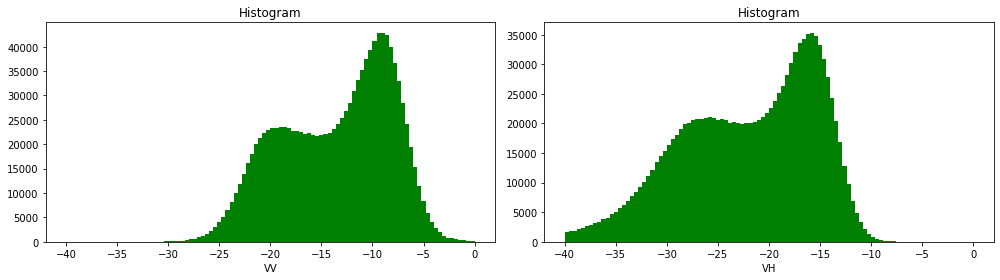

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sar_dataset.isel(time=acq_ind_to_show).VV.plot.hist(ax=ax[0], bins=100, range=(-40,0), facecolor='green')
sar_dataset.isel(time=acq_ind_to_show).VH.plot.hist(ax=ax[1], bins=100, range=(-40,0), facecolor='green')
plt.tight_layout()
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in VV and VH image products. This process is explained here. Gamma-nought backscatter amplitude (in dB units) is converted to raw (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [ ]:
# Primary VV band range is -2dB to -25dB which is DN=0.79 to DN=0.056
# Primary VH band range is -8dB to -40dB which is DN=0.40 to DN=0.01
# Primary VV/VH range is 0.0 to 1.0. This data is scaled by 60 for improved color contrast

vv_convert = (10**(sar_dataset.VV/20)-0.056)*350
vh_convert = (10**(sar_dataset.VH/20)-0.01)*650
sar_dataset['vv_amp'] = vv_convert
sar_dataset['vh_amp'] = vh_convert
sar_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 60

## VV, VH and RGB images

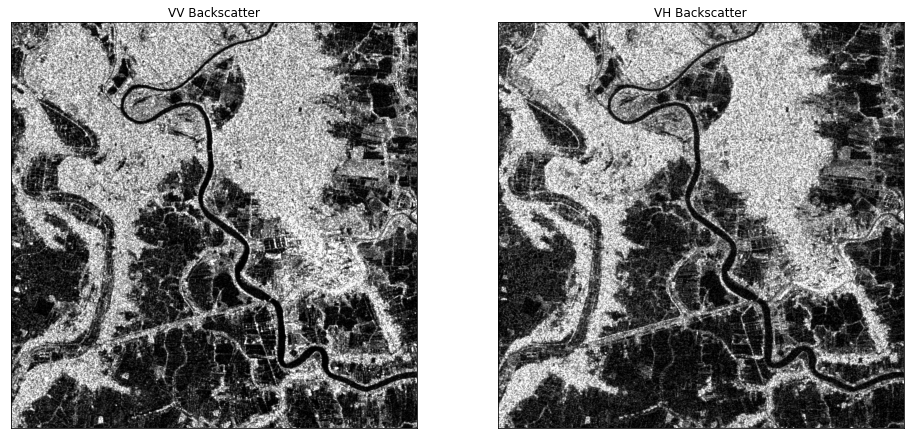

In [ ]:
# Plots of VV and VH Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb(sar_dataset.isel(time=acq_ind_to_show), ax=ax[0], bands=['vv_amp','vv_amp','vv_amp'])
rgb(sar_dataset.isel(time=acq_ind_to_show), ax=ax[1], bands=['vh_amp','vh_amp','vh_amp'])
ax[0].set_title('VV Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('VH Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

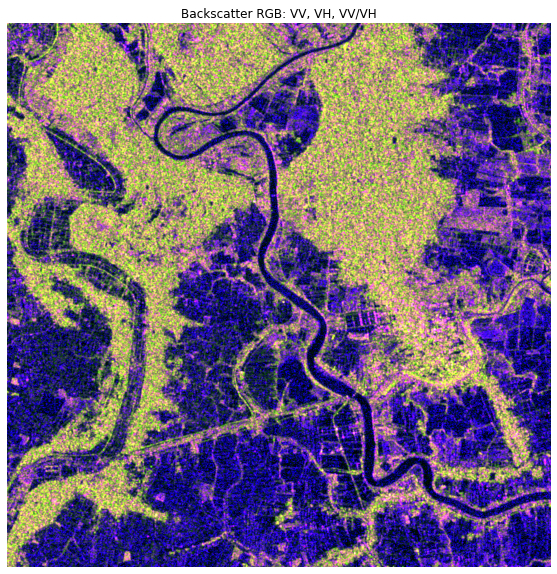

In [ ]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# New vegetation and urban areas are MAGENTA in color (due to high overall scattering and higher VV compared to VH)
# Low vegetation areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water is BLACK (low backscatter in both bands with similar VV and VH)

rgb(sar_dataset.isel(time=acq_ind_to_show),bands=['vv_amp','vh_amp','vvvh_amp'], width=10)
plt.title('Backscatter RGB: VV, VH, VV/VH')
plt.axis('off')
plt.show()

## Multi-Date RGB Land Change Product

In [ ]:
# Define a custom RGB - This custom RGB allows specific bands and time slices to be assigned to each color
# This custom RGB can be valuable for viewing land changes between two time periods

def custom_rgb(dataset, rgb_to_data_arr_ind_map, **rgb_kwargs):
    rgb_data = {}
    for channel, [data_var, time_ind] in zip(['red', 'green', 'blue'], rgb_to_data_arr_ind_map):
        rgb_data[channel] = dataset[data_var].isel(time=time_ind)
        rgb_data[channel] = rgb_data[channel].drop('time').to_array()
    rgb_data = xr.Dataset(rgb_data).squeeze('variable')
    rgb_kwargs['dataset'] = rgb_data
    rgb(**rgb_kwargs)
    return fig, ax

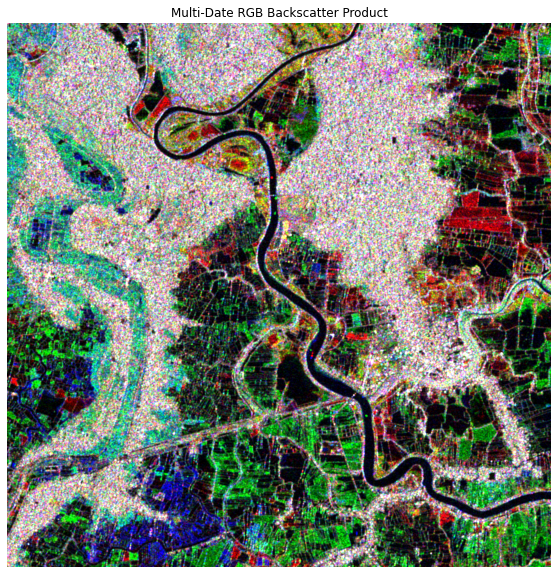

In [ ]:
# MODIFY HERE

# Define a custom RGB image using multiple dates and bands
# This product can be useful to view land change between different time periods

# Select the band: 'vv_amp' or 'vh_amp'
band = ['vv_amp']

# Selent the scene index for each color: Red, Green, Blue
first_scene = 0    # This is the RED color
second_scene = 10  # This is the GREEN color
third_scene = 20   # This is the BLUE color

# The baseline example is a rice crop region in Bangladesh
# The product displays VV band data on 3 different dates separated by about 2 months
# Red = 0 (2020-01-05), Green = 10 (2020-03-05) and Blue = 20 (2020-05-04)

# Color Interpretation for output results
# Red areas have high vegetation (cropping) at the early date
# Green areas have high vegetation (cropping) at the middle date
# Blue areas have high vegetation (cropping) at the later date
# Cyan (mix of green and blue) have higher vegetation in 2nd and 3rd dates compared to 1st date
# Magenta (mix of red and blue) have higher vegetation in 1st and 3rd dates compared to 2nd date
# Yellow (mix of red and green) have higher vegetation in 1st and 2nd dates compared to 3rd date
# Grey regions are high scattering (all dates) due to tree foliage or grass vegetation
# Black regions are low scattering (all dates) due to water or low vegetation (bare soils)

rgb_to_data_arr_ind_map = [[band,first_scene],[band,second_scene],[band,third_scene]]
custom_rgb(sar_dataset, rgb_to_data_arr_ind_map, width=10)
plt.title('Multi-Date RGB Backscatter Product')
plt.axis('off')
plt.show()

## Multi-Date Single-Band Threshold Land Change Product

In [ ]:
# MODIFY HERE

# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above
# first_acq_ind = First time slice acquisition
# second_acq_ind = Second time slice acquisition

first_acq_ind = 0
second_acq_ind = 20

# Select the variable to plot: vv or vh

threshold_variable = 'VV'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range
# GREEN = Pixels MORE than the high end of the threshold range

threshold_range = (-3, 3)

In [ ]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_gain = np.array([0,255,0]) # backscatter increase (GREEN)
color_black = np.array([0,0,0]) # low backscatter change, water (BLACK)

first_acq = sar_dataset.isel(time=first_acq_ind)
second_acq = sar_dataset.isel(time=second_acq_ind)
change_product = second_acq[threshold_variable] - first_acq[threshold_variable]

below_th = change_product.values < threshold_range[0]
above_th = threshold_range[1] < change_product.values

In [ ]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels and not show false change

water = first_acq[threshold_variable].values < -13.0

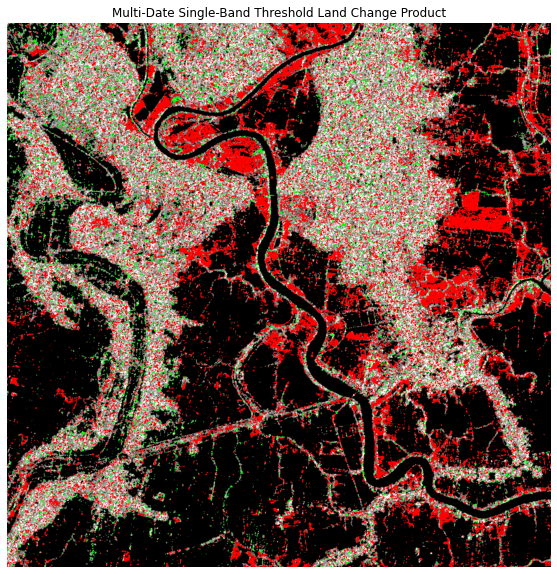

In [ ]:
# Create a custom threshold plot to identify land change
# The background image VV backscatter (grey-scale)
# RED areas have decreased backscatter or a loss of vegetation
# GREEN areas have increased backscatter or an increase in vegetation
# BLACK areas have no significant backscatter change or are water

rgb(first_acq, bands=['vv_amp', 'vv_amp', 'vv_amp'], 
    paint_on_mask=[(below_th, color_loss),(above_th, color_gain),(water, color_black)], width=10)
plt.title('Multi-Date Single-Band Threshold Land Change Product')
plt.axis('off')
plt.show()